In [ ]:
import os
import torch
from transformers import AutoTokenizer, BertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from transformers import Trainer, TrainingArguments, EarlyStoppingCallback
import numpy as np
from datasets import load_dataset,interleave_datasets,Dataset
import kagglehub
import matplotlib.pyplot as plt
from collections import Counter
import nltk
import evaluate

In [73]:
nltk.download('punkt')
MODEL_NAME = "bert-base-uncased"
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
metric = evaluate.load("accuracy")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\USER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [74]:
path = kagglehub.dataset_download("emineyetm/fake-news-detection-datasets")

base_path = os.path.join(path, "News _dataset")

file_dict = [
    {"name": "Fake.csv", "label": 1},
    {"name": "True.csv", "label": 0}
]

fake_ds = load_dataset("csv", data_files=os.path.join(base_path,"Fake.csv"))["train"]
true_ds = load_dataset("csv", data_files=os.path.join(base_path,"True.csv"))["train"]

fake_ds = fake_ds.map(lambda x: {"label": 1})
true_ds = true_ds.map(lambda x: {"label": 0})

full_dataset = Dataset.from_dict({
    "title": list(fake_ds["title"]) + list(true_ds["title"]),
    "text":  list(fake_ds["text"])  + list(true_ds["text"]),
    "label": list(fake_ds["label"]) + list(true_ds["label"]),
})

full_dataset = full_dataset.shuffle(seed=42)
print(Counter(full_dataset["label"]))


Counter({1: 23481, 0: 21417})


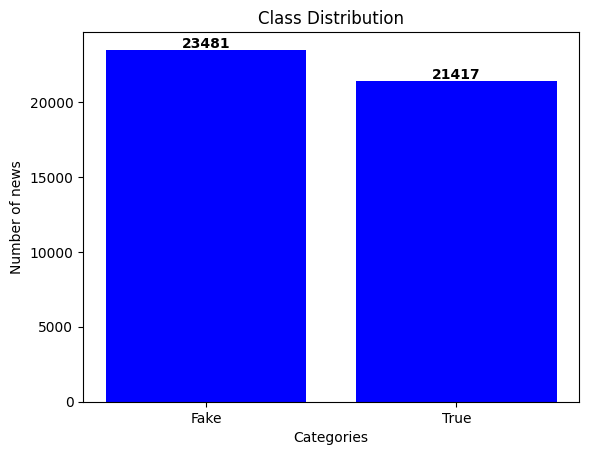

In [75]:
categories = ["Fake","True"]

values = [len(fake_ds), len(true_ds)]

plt.bar(categories,values,color="blue")
plt.xlabel("Categories")
plt.ylabel("Number of news")
plt.title("Class Distribution")
for i,v in enumerate(values):
    plt.text(i,v+100,str(v),ha="center",fontweight="bold")
plt.show()


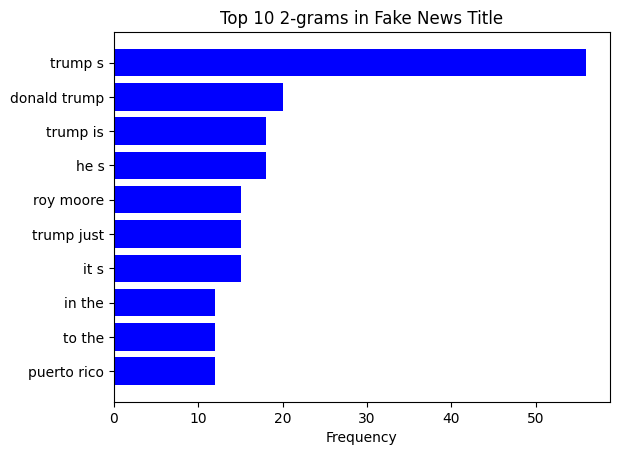

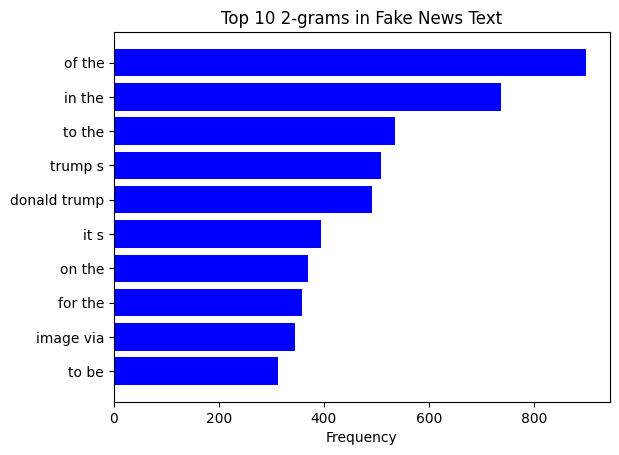

In [76]:
def tokenize(stream,type,num_samples=500):
    tokens = []
    for i,row in enumerate(stream):
        if i >= num_samples: 
            break
        
        token = [word.lower() for word in nltk.word_tokenize(row[type]) if any(c.isalpha() for c in word)]
        tokens.extend(token)
        
    return tokens
    
def ngram(tokens,n,title_name):
    n_grams = list(nltk.ngrams(tokens,n))
    ngram_count = Counter(n_grams)
    
    most_common = ngram_count.most_common(10)
    labels = [" ".join(item[0]) for item in most_common]
    counts = [item[1] for item in most_common]
    
    plt.barh(labels,counts,color="blue")
    plt.xlabel("Frequency")
    plt.title(f"Top 10 {n}-grams in {title_name}")
    plt.gca().invert_yaxis()
    plt.show()
    
fake_title_tokens = tokenize(fake_ds,"title")
ngram(fake_title_tokens,n=2,title_name="Fake News Title")
fake_text_tokens = tokenize(fake_ds,"text")
ngram(fake_text_tokens,n=2,title_name="Fake News Text")

In [77]:
def preprocess_function(examples):
    model_inputs = tokenizer(examples["text"],max_length=256,truncation=True,padding="max_length")
    model_inputs["labels"] = examples["label"]
    return model_inputs

n_samples = min(50000, len(full_dataset))
full_dataset = Dataset.from_list(list(full_dataset.take(n_samples)))

train_test = full_dataset.train_test_split(test_size=0.2, seed=42)
valid_test = train_test["test"].train_test_split(test_size=0.5, seed=42)

train_dataset = train_test["train"]
valid_dataset = valid_test["train"]
test_dataset  = valid_test["test"]

def label_dist(ds, name):
    print(name, Counter(ds["label"]))

label_dist(train_dataset, "Train")
label_dist(valid_dataset, "Valid")
label_dist(test_dataset,  "Test")

tokenized_test = test_dataset.map(preprocess_function,batched=True)
tokenized_valid = valid_dataset.map(preprocess_function,batched=True)
tokenized_train = train_dataset.map(preprocess_function,batched=True)

Train Counter({1: 18758, 0: 17160})
Valid Counter({1: 2396, 0: 2094})
Test Counter({1: 2327, 0: 2163})


Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/4490 [00:00<?, ? examples/s]

Map:   0%|          | 0/35918 [00:00<?, ? examples/s]

In [78]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits,axis=-1)
    
    precision,recall,f1, _ = precision_recall_fscore_support(
        labels, predictions,average="macro",zero_division=0
    )
    
    acc = accuracy_score(labels,predictions)
    
    return {
        "accuracy": acc,
        "f1": f1,
        "precision": precision,
        "recall": recall,
    }

In [ ]:
model = BertForSequenceClassification.from_pretrained(MODEL_NAME,num_labels=2).to(device)
model.config.hidden_dropout_prob = 0.3
model.config.attention_probs_dropout_prob = 0.3

for param in model.bert.parameters():
    param.requires_grad = False
    
training_args = TrainingArguments(
    output_dir="./FakeNewsDetector/results",
    fp16=True,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    weight_decay=0.05,
    warmup_ratio=0.1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

print("Start training ...")
trainer.train()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Start training ...


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.602600,0.592786,0.795323,0.793542,0.795487,0.792662
2,0.568400,0.561458,0.820935,0.820175,0.820086,0.820272


TrainOutput(global_step=4490, training_loss=0.6147675444129315, metrics={'train_runtime': 404.4472, 'train_samples_per_second': 177.615, 'train_steps_per_second': 11.102, 'total_flos': 9450422886420480.0, 'train_loss': 0.6147675444129315, 'epoch': 2.0})

In [80]:
test_result = trainer.evaluate(eval_dataset=tokenized_test)
print(f"Test Accuracy: {test_result['eval_accuracy']:.2%}")

Test Accuracy: 82.34%


In [81]:
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=-1)
labels = predictions.label_ids
print("\nDetailed Classification Report:")
print(classification_report(labels, preds, target_names=["True News", "Fake News"]))


Detailed Classification Report:
              precision    recall  f1-score   support

   True News       0.82      0.81      0.82      2163
   Fake News       0.83      0.83      0.83      2327

    accuracy                           0.82      4490
   macro avg       0.82      0.82      0.82      4490
weighted avg       0.82      0.82      0.82      4490



In [82]:
trainer.save_model("./FakeNewsDetector/final_model")
tokenizer.save_pretrained("./FakeNewsDetector/final_model")

('./FakeNewsDetector/final_model\\tokenizer_config.json',
 './FakeNewsDetector/final_model\\special_tokens_map.json',
 './FakeNewsDetector/final_model\\vocab.txt',
 './FakeNewsDetector/final_model\\added_tokens.json',
 './FakeNewsDetector/final_model\\tokenizer.json')